import the needed libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tnrange
import cProfile

load in the needed data

In [3]:
# load in the trace and plaintexts files
traces = np.load('traces_attack_hw3/traces_attack_int16.npy')
plaintext = np.load('traces_attack_hw3/textin_attack.npy')
ciphertext = np.load('traces_attack_hw3/textout_attack.npy')

plot the SNR plot to narrow down the points of interests

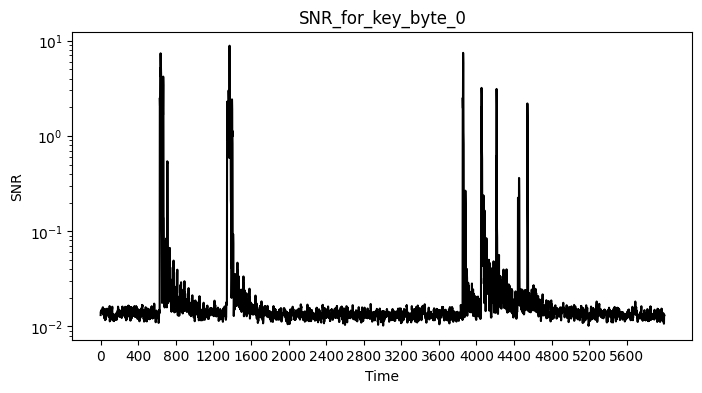

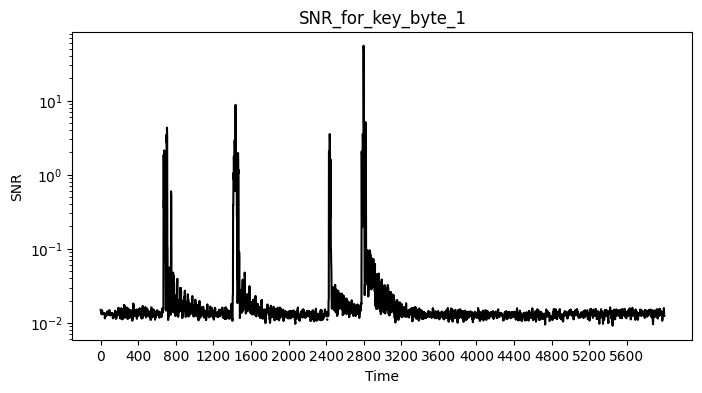

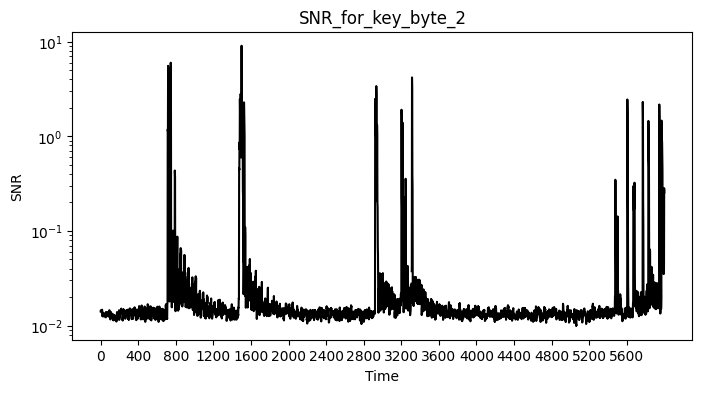

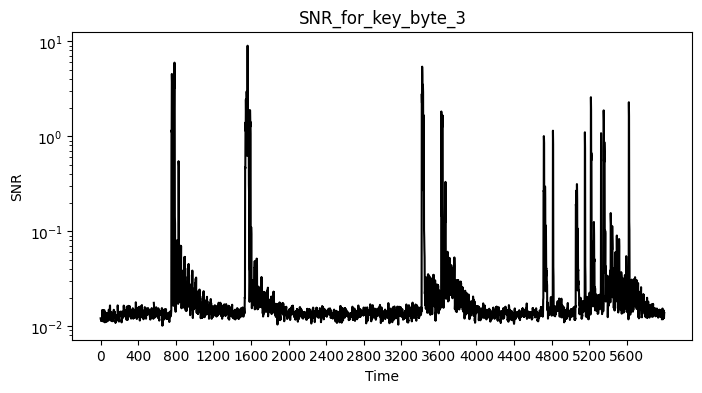

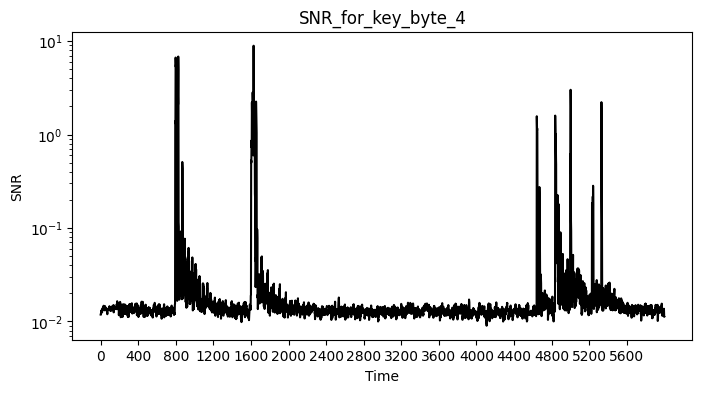

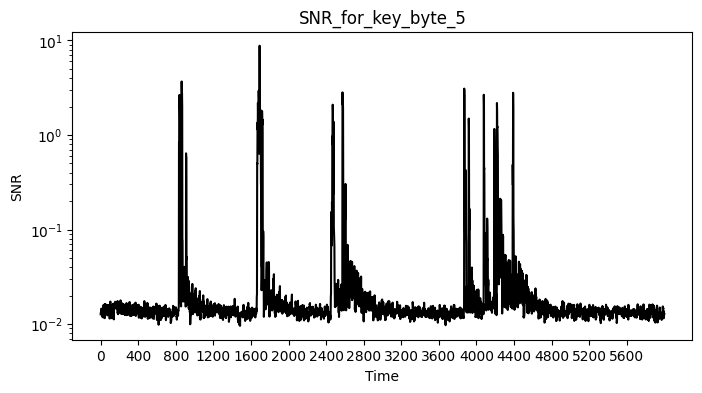

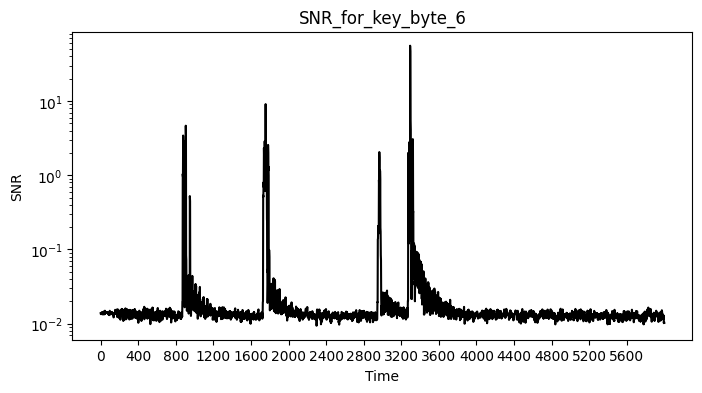

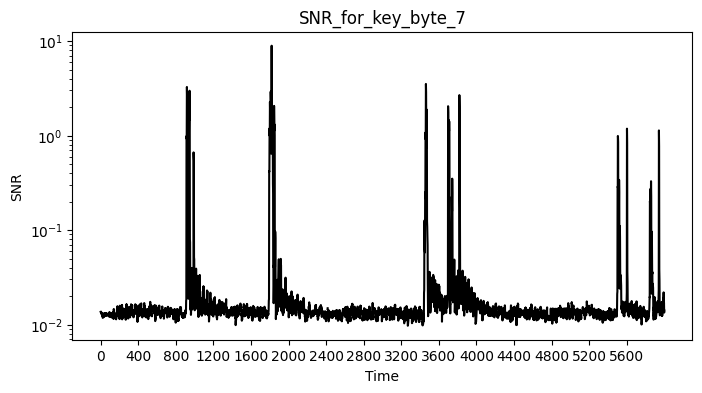

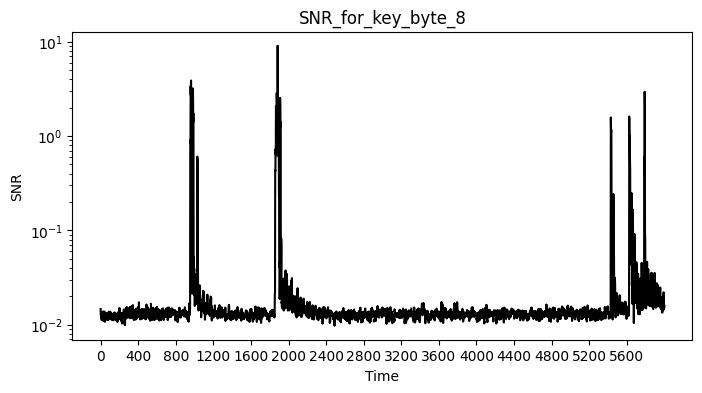

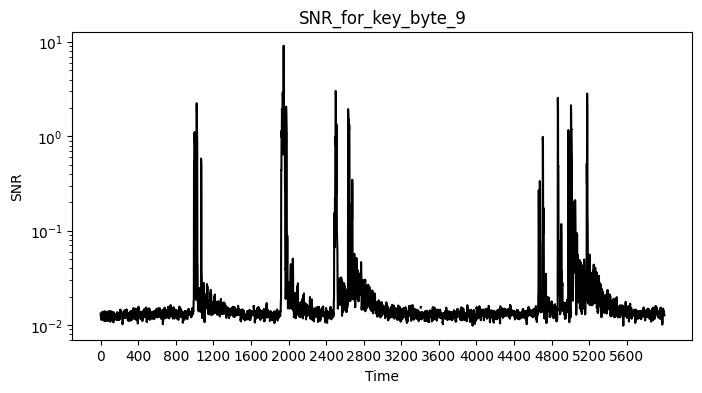

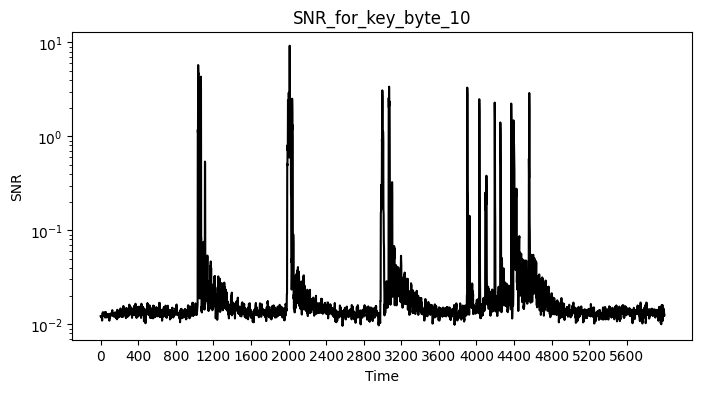

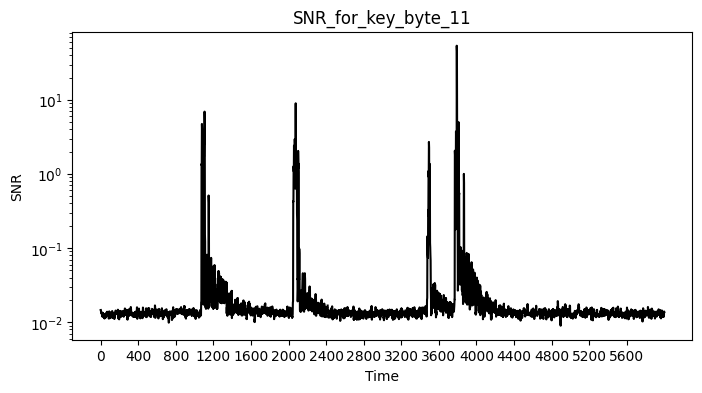

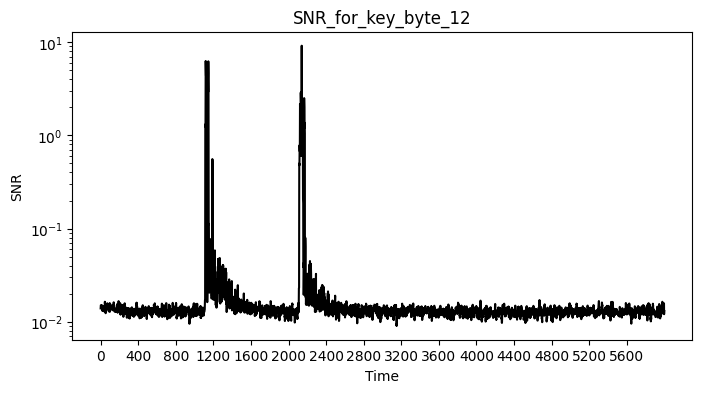

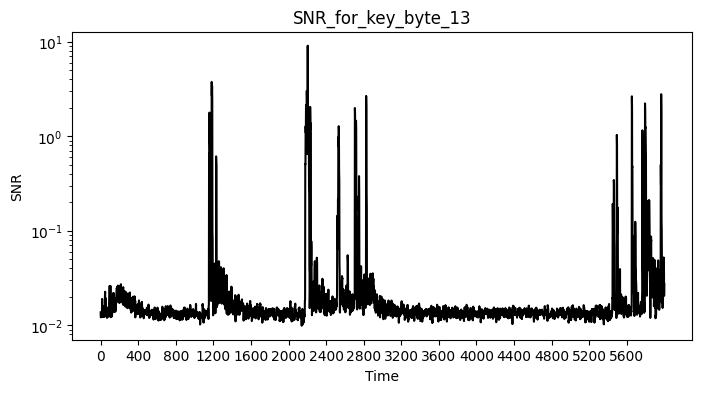

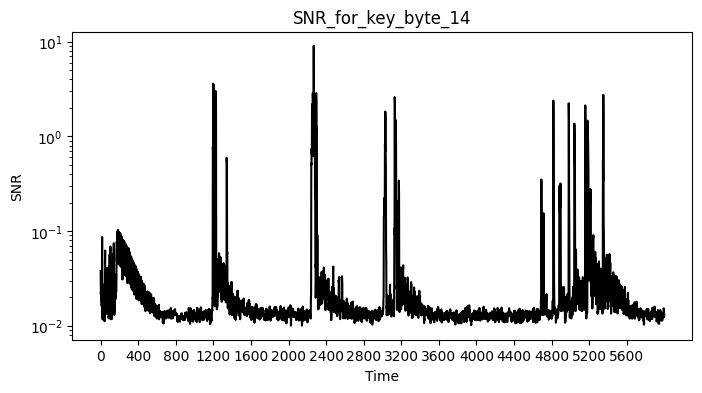

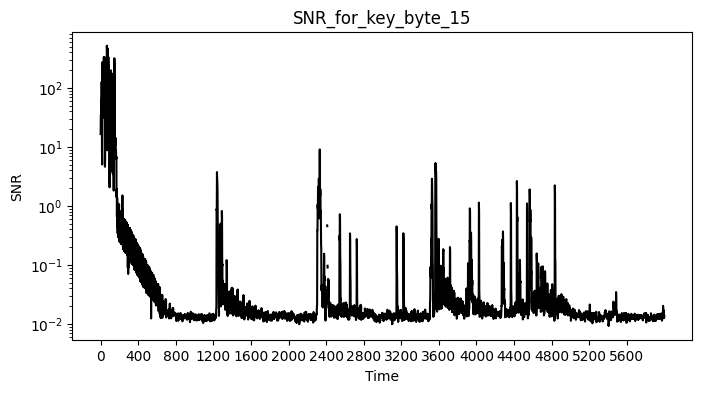

In [6]:
# Q2(a) - create the SNR plots based on the plaintext input

for byte in range(16):
    num = []
    denum = []
    for i in range(256):
        mask2 = (plaintext[:, byte] == i)
        rows = np.where(mask2)[0]
        selected_rows_in_trace = traces[rows, :6000]

        if selected_rows_in_trace.shape[0] != 0:
            num.append(np.mean(selected_rows_in_trace, axis=0))
            denum.append(np.var(selected_rows_in_trace, axis=0))
    
    signal = np.var(num, axis=0)
    noise = np.mean(denum, axis=0)
    
    # Set the invalid value to 'ignore'
    np.seterr(invalid='ignore')

    SNR = np.divide(signal, noise)

    %matplotlib inline
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(SNR, 'black')
    plt.yscale("log")

    dest2 = "figures/" + "key_" + "byte_" + str(byte)
    title = "SNR_for_key_" + "byte_" + str(byte)

    plt.xticks(np.arange(0, 6000, 400))
    plt.title(title)
    ax.set_xlabel('Time')
    ax.set_ylabel('SNR')

    plt.savefig(dest2)
    plt.show()

average multiple traces with the same input data to remove noise

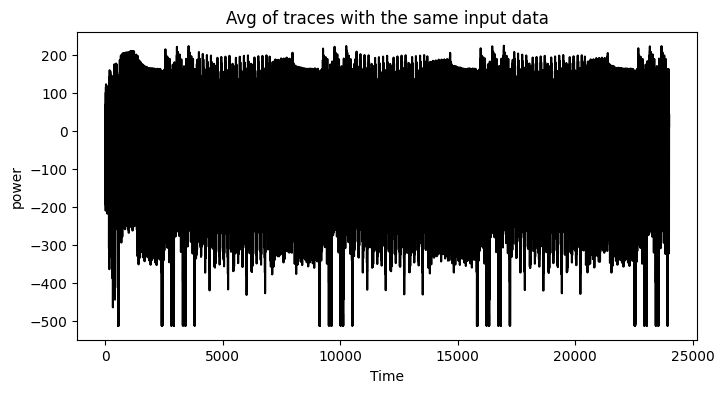

In [9]:
# Q2(b) - create a plot where multiple traces are averaged to remove the noise

for i in range(256):
    mask2 = (plaintext[:, 0] == i)
    rows = np.where(mask2)[0]
    selected_rows_in_trace = traces[rows, :]

    if selected_rows_in_trace.shape[0] != 0:
        avg_of_traces = np.mean(selected_rows_in_trace, axis=0)
        
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(avg_of_traces, 'black')

    dest2 = "figures/" + "avg_" + "power_" + "trace"
    title = "Avg of traces with the same input data"

    plt.title(title)
    ax.set_xlabel('Time')
    ax.set_ylabel('power')

    # plt.savefig(dest2)
    plt.show()
    break

create an array of the sbox for indexing

In [8]:
sbox = [
0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76,
0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0,
0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15,
0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75,
0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84,
0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf,
0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8,
0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2,
0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73,
0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb,
0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79,
0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08,
0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a,
0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e,
0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf,
0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16
]

sbox_arr = np.array(sbox).reshape(16,16)

define some utility funcs

In [10]:
def mean(X):
    return np.mean(X, axis=0)

def std_dev(X, X_bar):
    return np.sqrt(np.sum((X-X_bar)**2, axis=0))

def cov(X, X_bar, Y, Y_bar):
    return np.sum((X-X_bar)*(Y-Y_bar), axis=0)

func to extract the keys with CPA using Hamming Weight on SubBytes as intermediate value

In [29]:
# Q2(c)(I) - function to extract the keys using subbytes int values and hamming weights model

def find_key_subbyte_hw(pos, no_samples, poi_str):

    poi_start, poi_end = map(int, poi_str.split(':'))

    # get the plaintext byte
    byte = plaintext[:no_samples, pos]

    # get the possible subkeys
    keys = np.arange(256, dtype=np.uint8)

    # repeat the plaintext byte along the columns to form a matrix of shape (no_samples, 256)
    byte_matrix = np.repeat(byte[:, np.newaxis], keys.shape[0], axis=1)

    # repeat the keys along the columns to form a matrix of shape (no_samples, 256)
    keys_matrix = np.tile(keys, (byte.shape[0], 1))

    # XOR each element in the plaintext matrix and keys_matrix
    xored_result = np.bitwise_xor(byte_matrix, keys_matrix)

    # do the Sbox substitution on the xored result to get the hypothetical intermediate values
    x_axis = xored_result >> 4
    y_axis = xored_result & 15
    shape = 256 * no_samples
    sub_res = sbox_arr[x_axis.reshape(1, shape), y_axis.reshape(1, shape)].reshape(no_samples, 256)

    # apply the Hamming weight power leakage model to the intermediate values
    hypo = (sub_res & 0x55) + (sub_res >>  1 & 0x55) # put count of each  2 bits into those  2 bits 
    hypo = (hypo & 0x33) + (hypo >>  2 & 0x33)  # put count of each  4 bits into those  4 bits 
    hypo = (hypo & 0x0F) + (hypo >>  4 & 0x0F) # put count of each  8 bits into those  8 bits

    # apply the correlation coefficient to extract the probable value for the guessed key byte
    maxcpa = np.zeros(256)

    # we don't need to redo the mean and std dev calculations for each key guess
    traces_arr = traces[:no_samples, poi_start:poi_end]
    trace_bar = mean(traces_arr)
    o_trace = std_dev(traces_arr, trace_bar)

    for i in range(256):
        hypo_col = hypo[:, i].reshape(no_samples, 1)
        
        hypo_col_bar = mean(hypo_col)
        o_hypo_col = std_dev(hypo_col, hypo_col_bar)
        correlation = cov(traces_arr, trace_bar, hypo_col, hypo_col_bar)
        cpaoutput = correlation/(o_trace*o_hypo_col)
        maxcpa[i] = max(abs(cpaoutput))

    return np.argmax(maxcpa), max(maxcpa)


extract the keys with Hamming Weight and SubBytes as intermediate value

In [30]:
all_bytes_poi = {0:'1200:1600', 1:'2500:2900', 2:'1200:1700', 3:'1200:1700', 4:'1400:1800', 5:'1600:1800', 6:'3200:3400', 7:'1700:1900',
                    8:'1700:2000', 9:'1800:2100', 10:'1900:2200', 11:'3700:4000', 12:'2000:2300', 13:'2100:2300', 14:'0:4000', 15:'0:4000'}

guessed_keybytes = []
corr_coefs = []
for pos in range(16):
    poi_range = all_bytes_poi[pos] # You can change this to whatever time range instead of choosing specific points of interest
    key, corr = find_key_subbyte_hw(pos, 4000, poi_range) # change the 2nd argument for the number of samples
    guessed_keybytes.append(key)
    corr_coefs.append(corr)

print("The extracted key bytes are: ", guessed_keybytes)
print("the best guessed correlations: ", corr_coefs)

The extracted key bytes are:  [43, 126, 21, 22, 40, 174, 210, 166, 170, 247, 21, 136, 9, 207, 79, 60]
the best guessed correlations:  [0.6453865771241162, 0.8535502084653921, 0.6710423206635319, 0.6760507503410397, 0.6262555091739614, 0.66895841642514, 0.8406618120987825, 0.6426888828996733, 0.6283705626632339, 0.6376922817827257, 0.6522624435573907, 0.8659636331381121, 0.6256287081699976, 0.6488194470081117, 0.7206034642781088, 0.8614645060813655]


get the measurement to disclosure (MTD) for HW/SubByte hypothesis

In [31]:
# for the measurement to disclosure for HW/SubByte hypothesis is:
hwsubByte_corrcoef_mtd_1 = []
key_43_encountered = False  # add a flag variable

for samples in range(100, 5000, 100):
    poi_range = '0:1600'
    key, corr = find_key_subbyte_hw(0, samples, poi_range) # change the 2nd argument for the number of samples
    hwsubByte_corrcoef_mtd_1.append(corr)
    if key == 43 and not key_43_encountered:
        print('the MTD is:', samples)
        key_43_encountered = True  # set flag to True

print("the correlations for the mtd for HW/SubByte hypothesis is ", hwsubByte_corrcoef_mtd_1)

the MTD is: 100
the correlations for the mtd for HW/SubByte hypothesis is  [0.6966778096708124, 0.6900146772289777, 0.6614127938216665, 0.6651151504967716, 0.6518069123985838, 0.6545730582682044, 0.6464193492439197, 0.6388501438401225, 0.6483548670892525, 0.6465898567781219, 0.6387485102701604, 0.6406372524874382, 0.6366319689523146, 0.639176938871263, 0.6371435374792155, 0.6374392519432368, 0.6403867895487444, 0.6386105135450888, 0.6376704830740542, 0.6338318671272276, 0.638251055217021, 0.6360735677251517, 0.6376628821565411, 0.6388824784093169, 0.6378642116083039, 0.6390719980499721, 0.6398186964472405, 0.6391331369874147, 0.6398754263985883, 0.6388479991080235, 0.6381678001690522, 0.6377209387333368, 0.6375227697735565, 0.639512153968495, 0.6408956704128832, 0.6429024785877416, 0.6439829159413368, 0.6431128092617565, 0.6431247777452257, 0.6453865771241162, 0.6468065288159628, 0.6475598203279682, 0.6460247818864885, 0.6434918867062721, 0.6438907768546435, 0.6456144207096249, 0.64483

func to extract the keys with CPA using Hamming Weight on KeyAdd as intermediate value

In [32]:
# Q2(c)(II) - function to extract the keys using keyAdd int values and hamming weights model

def find_key_add_hw(pos, no_samples, poi_str):

    poi_start, poi_end = map(int, poi_str.split(':'))

    # get the plaintext byte
    byte = plaintext[:no_samples, pos]

    # get the possible subkeys
    keys = np.arange(256, dtype=np.uint8)

    # repeat the plaintext byte along the columns to form a matrix of shape (no_samples, 256)
    byte_matrix = np.repeat(byte[:, np.newaxis], keys.shape[0], axis=1)

    # repeat the keys along the columns to form a matrix of shape (no_samples, 256)
    keys_matrix = np.tile(keys, (byte.shape[0], 1))

    # XOR each element in the plaintext matrix and keys_matrix
    xored_result = np.bitwise_xor(byte_matrix, keys_matrix)

    # apply the Hamming weight power leakage model to the intermediate values
    hypo = (xored_result & 0x55) + (xored_result >>  1 & 0x55) # put count of each  2 bits into those  2 bits 
    hypo = (hypo & 0x33) + (hypo >>  2 & 0x33)  # put count of each  4 bits into those  4 bits 
    hypo = (hypo & 0x0F) + (hypo >>  4 & 0x0F) # put count of each  8 bits into those  8 bits

    # apply the correlation coefficient to extract the probable value for the guessed key byte
    maxcpa = np.zeros(256)

    # we don't need to redo the mean and std dev calculations for each key guess
    traces_arr = traces[:no_samples, poi_start:poi_end]
    trace_bar = mean(traces_arr)
    o_trace = std_dev(traces_arr, trace_bar)

    for i in range(256):
        hypo_col = hypo[:, i].reshape(no_samples, 1)
        
        hypo_col_bar = mean(hypo_col)
        o_hypo_col = std_dev(hypo_col, hypo_col_bar)
        correlation = cov(traces_arr, trace_bar, hypo_col, hypo_col_bar)
        cpaoutput = correlation/(o_trace*o_hypo_col)
        maxcpa[i] = max(abs(cpaoutput))

    return np.argmax(maxcpa), max(maxcpa)

extract the keys with Hamming Weight and KeyAdd as intermediate value

In [33]:
guessed_keybytes = []
corr_coefs = []
for pos in range(16):
    poi_range = all_bytes_poi[pos] # You can change this to whatever time range instead of choosing specific points of interest
    key, corr = find_key_add_hw(pos, 4000, poi_range) # change the 2nd argument for the number of samples
    guessed_keybytes.append(key)
    corr_coefs.append(corr)

print("The extracted key bytes are: ", guessed_keybytes)
print("the best guessed correlations: ", corr_coefs)

The extracted key bytes are:  [43, 177, 21, 233, 215, 81, 29, 89, 84, 247, 234, 71, 9, 207, 79, 0]
the best guessed correlations:  [0.7849189798997483, 0.19118411088604684, 0.7940733202552364, 0.7625738600628336, 0.7788662710407364, 0.7392218751997908, 0.23201387235126658, 0.7306338466904104, 0.7373240212825029, 0.7161306945730432, 0.758654093830553, 0.22778067204251903, 0.75402861449555, 0.7153766513765992, 0.7937618358023023, 0.8959185570744564]


get the measurement to disclosure (MTD) for HW/KeyAdd hypothesis

In [34]:
# for the measurement to disclosure for HW/KeyAdd hypothesis is:
hwsubByte_corrcoef_mtd_2 = []
key_43_encountered = False  # add a flag variable

for samples in range(100, 5000, 100):
    poi_range = '0:1600'
    key, corr = find_key_add_hw(0, samples, poi_range) # change the 2nd argument for the number of samples
    hwsubByte_corrcoef_mtd_2.append(corr)
    if key == 43 and not key_43_encountered:
        print('the MTD is:', samples)
        key_43_encountered = True  # set flag to True

print("the correlations for the mtd for HW/SubByte hypothesis is ", hwsubByte_corrcoef_mtd_2)

the MTD is: 100
the correlations for the mtd for HW/SubByte hypothesis is  [0.8416303812717969, 0.8542538161433729, 0.8555329172948956, 0.848564389953614, 0.8516097202223764, 0.8398340389802588, 0.842155653311117, 0.846827417715446, 0.846145625107604, 0.8506227445105954, 0.8497858423246469, 0.8524076165528024, 0.8502008674246534, 0.8506987273415104, 0.8515785925946484, 0.8513137442403432, 0.8520458499764048, 0.8529008289084875, 0.8510516237886826, 0.849403164614114, 0.8478175746375467, 0.8472429535545273, 0.848529215646418, 0.8487505418280608, 0.8476052397565763, 0.8478520430377597, 0.848444099233355, 0.8480609371012465, 0.8473407202267892, 0.8468964047957183, 0.8464951353899813, 0.8463991815832835, 0.846200169022075, 0.8468135983215158, 0.8469776276731705, 0.8460284914212877, 0.8461523490100834, 0.8455969659020349, 0.8454012084208181, 0.846733747118831, 0.8460697374471875, 0.8455931125874322, 0.8454090813853304, 0.8460151835365246, 0.8461511103368289, 0.8455196438010594, 0.84460018194

In [ ]:
# profiling the code
# cProfile.run('find_key_subbyte(0, 20000, 5000)')

func to extract the keys with CPA using Hamming Distance on SubBytes as intermediate value

In [35]:
# Q2(c)(III) - function to extract the keys using subbytes int values and hamming distance model

def find_key_subbyte_hd(pos, no_samples, poi_str):

    poi_start, poi_end = map(int, poi_str.split(':'))

    # get the plaintext byte
    byte = plaintext[:no_samples, pos]

    # get the possible subkeys
    keys = np.arange(256, dtype=np.uint8)

    # repeat the plaintext byte along the columns to form a matrix of shape (no_samples, 256)
    byte_matrix = np.repeat(byte[:, np.newaxis], keys.shape[0], axis=1)

    # repeat the keys along the columns to form a matrix of shape (no_samples, 256)
    keys_matrix = np.tile(keys, (byte.shape[0], 1))

    # XOR each element in the plaintext matrix and keys_matrix
    xored_result = np.bitwise_xor(byte_matrix, keys_matrix)

    # do the Sbox substitution on the xored result to get the hypothetical intermediate values
    x_axis = xored_result >> 4
    y_axis = xored_result & 15
    shape = 256 * no_samples
    sub_res = sbox_arr[x_axis.reshape(1, shape), y_axis.reshape(1, shape)].reshape(no_samples, 256)

    # apply the Hamming distance power leakage model to the intermediate values
    bits_a = np.unpackbits(np.expand_dims(np.uint8(xored_result), axis=-1), axis=-1)
    bits_b = np.unpackbits(np.expand_dims(np.uint8(sub_res), axis=-1), axis=-1)
    diff = bits_a != bits_b
    hypo = np.sum(diff, axis=-1)

    # apply the correlation coefficient to extract the probable value for the guessed key byte
    maxcpa = np.zeros(256)

    # we don't need to redo the mean and std dev calculations for each key guess
    traces_arr = traces[:no_samples, poi_start:poi_end]
    trace_bar = mean(traces_arr)
    o_trace = std_dev(traces_arr, trace_bar)

    for i in range(256):
        hypo_col = hypo[:, i].reshape(no_samples, 1)
        
        hypo_col_bar = mean(hypo_col)
        o_hypo_col = std_dev(hypo_col, hypo_col_bar)
        correlation = cov(traces_arr, trace_bar, hypo_col, hypo_col_bar)
        cpaoutput = correlation/(o_trace*o_hypo_col)
        maxcpa[i] = max(abs(cpaoutput))

    return np.argmax(maxcpa), max(maxcpa)

extract the keys with Hamming Distance and SubByte as intermediate value

In [36]:
guessed_keybytes = []
corr_coefs = []
for pos in range(16):
    poi_range = all_bytes_poi[pos] # You can change this to whatever time range instead of choosing specific points of interest
    key, corr = find_key_subbyte_hd(pos, 4000, poi_range) # change the 2nd argument for the number of samples
    guessed_keybytes.append(key)
    corr_coefs.append(corr)

print("The extracted key bytes are: ", guessed_keybytes)
print("the best guessed correlations: ", corr_coefs)

The extracted key bytes are:  [144, 136, 175, 172, 147, 20, 36, 29, 16, 76, 175, 126, 179, 116, 244, 100]
the best guessed correlations:  [0.1995430120412925, 0.23974159198777964, 0.21284540288289755, 0.21232439338354317, 0.22158889961788408, 0.21032613459124222, 0.18427211957986464, 0.19085464809436603, 0.22607967655615424, 0.21010623909055773, 0.2036004930614009, 0.18501177175423247, 0.20695872423435102, 0.20356913257646206, 0.2098397463592359, 0.22963781540796144]


get the measurement to disclosure (MTD) for HD/SubBytes hypothesis

In [37]:
# for the measurement to disclosure for HD/SubByte hypothesis is:
hdsubByte_corrcoef_mtd = []
key_144_encountered = False  # add a flag variable

for samples in range(100, 5000, 100):
    poi_range = '0:1600'
    key, corr = find_key_subbyte_hd(0, samples, poi_range) # change the 2nd argument for the number of samples
    hdsubByte_corrcoef_mtd.append(corr)
    if key == 144 and not key_144_encountered:
        print('the MTD is:', samples)
        key_144_encountered = True  # set flag to True

print("the correlations for the mtd for HD/SubByte hypothesis is ", hdsubByte_corrcoef_mtd)

the MTD is: 300
the correlations for the mtd for HD/SubByte hypothesis is  [0.411321068461049, 0.32903088229271255, 0.30134638181671675, 0.28834492479268425, 0.2862513847825507, 0.27115147833163666, 0.241162534861582, 0.2465893997973922, 0.22556913382746116, 0.21206246774281745, 0.21919188079935129, 0.20816121190018386, 0.2163554873244706, 0.21811623271280192, 0.20792327050969034, 0.20511449552298258, 0.20537639051880308, 0.2072344179273974, 0.2045852650526959, 0.20924008471147632, 0.2000319027337199, 0.2054249296264885, 0.20966400844170607, 0.20655709610633236, 0.20332476359129553, 0.20723918977881403, 0.20462138461698445, 0.20858630802695077, 0.21314539576850555, 0.21022827939742994, 0.2074611080532837, 0.20371261887598752, 0.20667887334096877, 0.20928820763306807, 0.2075652301255124, 0.20760219531375812, 0.20729371577122557, 0.2045626751263518, 0.2029494863437743, 0.1995430120412925, 0.19782056124791877, 0.199295097353765, 0.19914279067313287, 0.19864352390761025, 0.1970695229925232

Plot the Measurement to Disclosure plots for all three hypotheses

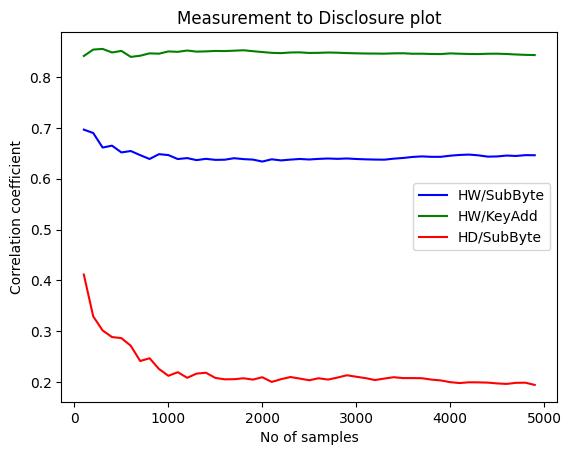

In [39]:
# Plot the MTD
no_samples = range(100, 5000, 100)
plt.plot(no_samples, hwsubByte_corrcoef_mtd_1, 'blue', label='HW/SubByte')
plt.plot(no_samples, hwsubByte_corrcoef_mtd_2, 'green', label='HW/KeyAdd')
plt.plot(no_samples, hdsubByte_corrcoef_mtd, 'red', label='HD/SubByte')
plt.ylabel('Correlation coefficient')
plt.xlabel('No of samples')
plt.title('Measurement to Disclosure plot')
plt.legend()

# Show the plot
plt.show()

load in the data for the welch t-test

In [53]:
# Task 3 - Standard t-test for leakage assessment
trace_0 = np.load('tvla_traces_hw3/tvla_0traces_int16.npy')
trace_1 = np.load('tvla_traces_hw3/tvla_1traces_int16.npy')

In [79]:
# define the function to perform the t-test
def t_test(trace_0, trace_1, axis_0):

    # Get the number of samples in each group
    n1 = trace_0.shape[axis_0]
    n2 = trace_1.shape[axis_0]

    # Convert the traces array to a floating-point data types
    trace_0 = trace_0.astype(float)
    trace_1 = trace_1.astype(float)

    # Set any rows with a value of 0 to NaN (which will be ignored in the mean and variance calculations)
    trace_0[trace_0 == 0] = np.nan
    trace_1[trace_1 == 0] = np.nan

    # Compute the mean and variance of each column of trace_0, ignoring any NaN values
    mean_0 = np.nanmean(trace_0, axis=axis_0)
    variance_0 = np.nanvar(trace_0, axis=axis_0)

    # Compute the mean and variance of each column of trace_1, ignoring any NaN values
    mean_1 = np.nanmean(trace_1, axis=0)
    variance_1 = np.nanvar(trace_1, axis=0)

    # Compute the t-test
    vn0 = variance_0 / n1
    vn1 = variance_1 / n2
    denom = np.sqrt(vn0 + vn1)

    diff = mean_0 - mean_1
    with np.errstate(divide='ignore', invalid='ignore'):
        t_test = np.divide(diff, denom)

    return t_test


# check the results of the t_test and return points where it failed
def check_t_test(t, threshold=4.5):
    failed_points = []
    for i in range(t.shape[0]):
        if np.logical_or(t[i] > threshold, t[i] < -threshold):
            failed_points.append(i)
    return failed_points

In [81]:
# call the t_test function and check the leakage points
test = t_test(trace_0, trace_1, 0)
fail_points = check_t_test(test)
print("The fail points for t-test on the two groups of traces are: ", fail_points)

The fail points for t-test on the two groups of traces are:  [535, 543, 2915, 9619, 10099, 10115, 10519, 16735, 23539]


plot the t-test result

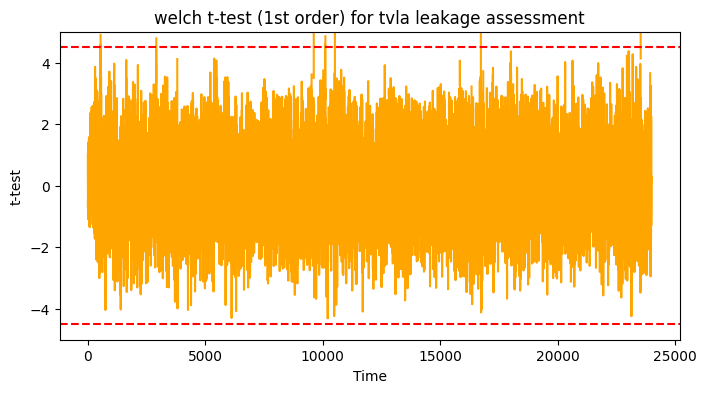

In [84]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(test, 'orange')

plt.title('welch t-test (1st order) for tvla leakage assessment')
ax.set_xlabel('Time')
ax.set_ylabel('t-test')

# Add horizontal lines at the threshold values of +4.5 and -4.5
ax.axhline(y=4.5, color='red', linestyle='--')
ax.axhline(y=-4.5, color='red', linestyle='--')

# Set y-axis limits to range from -5 to +5
ax.set_ylim([-5, 5])

plt.show()

alternate func to perform the t-test independently for each group based on <https://csrc.nist.gov/csrc/media/events/non-invasive-attack-testing-workshop/documents/08_goodwill.pdf>

In [76]:
def ttest_ind(a, b, axis=0):
    n1 = a.shape[axis]
    n2 = b.shape[axis]

    v1 = np.var(a, axis = axis)
    v2 = np.var(b, axis = axis)
    m1 = np.mean(a, axis)
    m2 = np.mean(b, axis)

    vn1 = v1 / n1
    vn2 = v2 / n2
    denom = np.sqrt(vn1 + vn2)

    d = m1 - m2
    with np.errstate(divide='ignore', invalid='ignore'):
        t_test = np.divide(d, denom)

    return t_test

def t_test_alt(group1, group2):
    """ Perform a t_test between two numpy arrays.
    Splits the data between the first and second half of each group
    Args:
        group1 (numpy.array): Group 1
        group2 (numpy.array): Group 2
    Returns:
        numpy.array: A numpy array with two elements spanning the length of the traces. The
        first is between the first half of groups 1 and 2. The second
        is between the second half of the groups.
    """
    group1_len = len(group1) // 2
    group2_len = len(group2) // 2

    t_0 = ttest_ind(group1[:group1_len], group2[:group2_len], axis=0)
    t_1 = ttest_ind(group1[group1_len:], group2[group2_len:], axis=0)

    test_res = [t_0, t_1]

    # print("The value of t after the t_test is: ", test_res)
    return test_res

def check_t_test_alt(t, threshold=4.5):
    """Check the results of the t_test and return points where it failed.
    Args:
        t (np.array(shape=(2, scope.adc.samples), dtype='float64')): t_test results
        threshold (float): If t[0] and t[1] are above threshold or below -threshold at
                            the same point, it is considered a failure point
    Returns:
        list of failed points
    """
    failed_points = []
    for i in range(len(t[0])):
        if ((t[0][i]) > threshold) or ((t[0][i]) < - threshold):
            failed_points.append(i)
        if ((t[1][i]) > threshold) or ((t[1][i]) < - threshold):
            failed_points.append(i)
    
    return failed_points

compute the t-test and return the fail points for the alternate t-test method

In [77]:
t_val= t_test_alt(trace_0, trace_1)
fail_points = check_t_test_alt(t_val)
print("The fail points for independent t-test on the two groups of traces are: ", fail_points)

The fail points for independent t-test on the two groups of traces are:  [1401, 2915, 3302, 3303, 3709, 5478, 5479, 10023, 10577, 10791, 20682, 20683, 22771]


plot the t-test result for the alternate t-test method

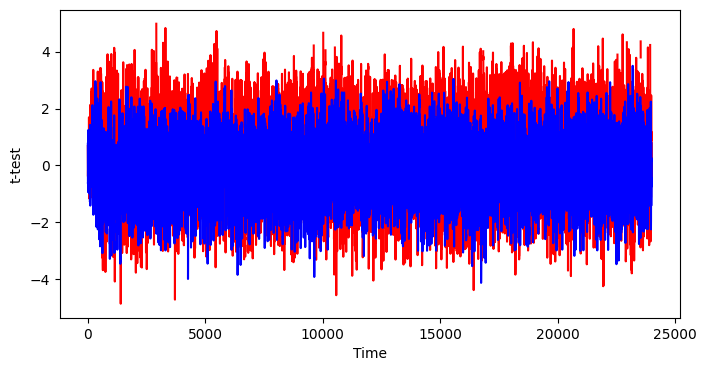

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(t_val[0], 'red')
ax.plot(t_val[1], 'blue')

plt.title('')
ax.set_xlabel('Time')
ax.set_ylabel('t-test')

# plt.savefig(dest2)
plt.show()